# Project 3

In this project, you will perform a logistic regression on the admissions data we've been working with in projects 1 and 2.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab as pl
import numpy as np


In [2]:
df_raw = pd.read_csv("admissions.csv")
df = df_raw.dropna() 
print(df.head())


   admit    gre   gpa  prestige
0      0  380.0  3.61       3.0
1      1  660.0  3.67       3.0
2      1  800.0  4.00       1.0
3      1  640.0  3.19       4.0
4      0  520.0  2.93       4.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397 entries, 0 to 399
Data columns (total 4 columns):
admit       397 non-null int64
gre         397 non-null float64
gpa         397 non-null float64
prestige    397 non-null float64
dtypes: float64(3), int64(1)
memory usage: 15.5 KB


In [4]:
df['prestige'] = df['prestige'].astype(np.int64)

c:\program files\python36\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397 entries, 0 to 399
Data columns (total 4 columns):
admit       397 non-null int64
gre         397 non-null float64
gpa         397 non-null float64
prestige    397 non-null int64
dtypes: float64(2), int64(2)
memory usage: 15.5 KB


## Part 1. Frequency Tables

#### 1. Let's create a frequency table of our variables

In [6]:
# frequency table for prestige and whether or not someone was admitted
df.groupby(['prestige'])['admit'].value_counts()

prestige  admit
1         1        33
          0        28
2         0        95
          1        53
3         0        93
          1        28
4         0        55
          1        12
Name: admit, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397 entries, 0 to 399
Data columns (total 4 columns):
admit       397 non-null int64
gre         397 non-null float64
gpa         397 non-null float64
prestige    397 non-null int64
dtypes: float64(2), int64(2)
memory usage: 15.5 KB


## Part 2. Return of dummy variables

#### 2.1 Create class or dummy variables for prestige 

In [8]:
dummy_ranks = pd.get_dummies(df.prestige, prefix='prestige')

dummy_ranks.head()

,prestige_1,prestige_2,prestige_3,prestige_4
0,0,0,1,0
1,0,0,1,0
2,1,0,0,0
3,0,0,0,1
4,0,0,0,1


#### 2.2 When modeling our class variables, how many do we need? 



Answer: n-1, in this case 3

## Part 3. Hand calculating odds ratios

Develop your intuition about expected outcomes by hand calculating odds ratios.

In [9]:
cols_to_keep = ['admit', 'gre', 'gpa']
handCalc = df[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_1':])
handCalc.head()

,admit,gre,gpa,prestige_1,prestige_2,prestige_3,prestige_4
0,0,380.0,3.61,0,0,1,0
1,1,660.0,3.67,0,0,1,0
2,1,800.0,4.00,1,0,0,0
3,1,640.0,3.19,0,0,0,1
4,0,520.0,2.93,0,0,0,1


In [10]:
#crosstab prestige 1 admission 
# frequency table cutting prestige and whether or not someone was admitted
crosstab_freq = pd.crosstab(handCalc['admit'], handCalc['prestige_1'], margins=True)
crosstab_freq

prestige_1,0,1,All
admit,,,
0,243,28,271
1,93,33,126
All,336,61,397


#### 3.1 Use the cross tab above to calculate the odds of being admitted to grad school if you attended a #1 ranked college

In [11]:
(crosstab_freq.iloc[1,1] / crosstab_freq.iloc[2,1]) / (crosstab_freq.iloc[0,1] / crosstab_freq.iloc[2,1])


1.1785714285714286

#### 3.2 Now calculate the odds of admission if you did not attend a #1 ranked college

In [12]:
(crosstab_freq.iloc[1,0] / crosstab_freq.iloc[2,0]) / (crosstab_freq.iloc[0,0] / crosstab_freq.iloc[2,0])


0.38271604938271608

#### 3.3 Calculate the odds ratio

In [13]:
p1 = (33/61)
p2 = (93/336)

OR = (p1/(1-p1))/(p2/(1-p2))

OR

3.079493087557604

#### 3.4 Write this finding in a sentenance: 

Answer: Applicants who came from a #1 ranked college were 3 times as likely to be admited than those who did not.

#### 3.5 Print the cross tab for prestige_4

In [14]:
crosstab_freq = pd.crosstab(handCalc['prestige_4'], handCalc.admit,margins=True)
crosstab_freq

admit,0,1,All
prestige_4,,,
0,216,114,330
1,55,12,67
All,271,126,397


#### 3.6 Calculate the OR 

In [15]:
p1 = (12/126)
p2 = (55/271)

OR = (p1/(1-p1))/(p2/(1-p2))

OR

0.4133971291866028

#### 3.7 Write this finding in a sentence

Answer: Students who came from the lowest ranked school were less than half as likely to get admitted.

## Part 4. Analysis

In [16]:
# create a clean data frame for the regression
cols_to_keep = ['admit', 'gre', 'gpa']
data = df[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_2':])
data.head()

,admit,gre,gpa,prestige_2,prestige_3,prestige_4
0,0,380.0,3.61,0,1,0
1,1,660.0,3.67,0,1,0
2,1,800.0,4.00,0,0,0
3,1,640.0,3.19,0,0,1
4,0,520.0,2.93,0,0,1


We're going to add a constant term for our Logistic Regression. The statsmodels function we're going to be using requires that intercepts/constants are specified explicitly.

In [17]:
# manually add the intercept
data['intercept'] = 1.0

#### 4.1 Set the covariates to a variable called train_cols

In [18]:
train_cols = ['gre', 'gpa', 'prestige_2', 'prestige_3', 'prestige_4', 'intercept']

#### 4.2 Fit the model

In [19]:
results = sm.Logit(data['admit'], data[train_cols]).fit()

Optimization terminated successfully.
         Current function value: 0.573854
         Iterations 6


#### 4.3 Print the summary results

In [20]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  admit   No. Observations:                  397
Model:                          Logit   Df Residuals:                      391
Method:                           MLE   Df Model:                            5
Date:                Mon, 28 Aug 2017   Pseudo R-squ.:                 0.08166
Time:                        08:28:29   Log-Likelihood:                -227.82
converged:                       True   LL-Null:                       -248.08
                                        LLR p-value:                 1.176e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
gre            0.0022      0.001      2.028      0.043    7.44e-05       0.004
gpa            0.7793      0.333      2.344      0.019       0.128       1.431
prestige_2    -0.6801      0.317     -2.146      0.032      -1.301      -0.059
prestige_3    -1.3387      0.345     -3.882      0.000      -2.015      -0.663
prestige_4    -1.5534      0.417     -3.721      0.000      -2.372      -0.735
intercept     -3.8769      1.142     -3.393      0.001      -6.116      -1.638
==============================================================================
"""

#### 4.4 Calculate the odds ratios of the coeffiencents and their 95% CI intervals

hint 1: np.exp(X)

hint 2: conf['OR'] = params
        
           conf.columns = ['2.5%', '97.5%', 'OR']

In [21]:
np.exp(results.params)

gre           1.002221
gpa           2.180027
prestige_2    0.506548
prestige_3    0.262192
prestige_4    0.211525
intercept     0.020716
dtype: float64

In [22]:
conf = results.conf_int()
conf['OR']= results.params
conf.columns=['2.5%', '97.5%', 'OR']
np.exp(conf)

,2.5%,97.5%,OR
gre,1.000074,1.004372,1.002221
gpa,1.136120,4.183113,2.180027
prestige_2,0.272168,0.942767,0.506548
prestige_3,0.133377,0.515419,0.262192
prestige_4,0.093329,0.479411,0.211525
intercept,0.002207,0.194440,0.020716


#### 4.5 Interpret the OR of Prestige_2

Answer: The odds of being admitted for Prestige_2 are 50% lower.

#### 4.6 Interpret the OR of GPA

Answer: As GPA increases the odds of being admitted increases.

## Part 5: Predicted probablities


As a way of evaluating our classifier, we're going to recreate the dataset with every logical combination of input values. This will allow us to see how the predicted probability of admission increases/decreases across different variables. First we're going to generate the combinations using a helper function called cartesian (above).

We're going to use np.linspace to create a range of values for "gre" and "gpa". This creates a range of linearly spaced values from a specified min and maximum value--in our case just the min/max observed values.

In [23]:
def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.
    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.
    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.
    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])
    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    #m = n / arrays[0].size
    m = n // arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in range(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [24]:
# instead of generating all possible values of GRE and GPA, we're going
# to use an evenly spaced range of 10 values from the min to the max 
gres = np.linspace(data['gre'].min(), data['gre'].max(), 10)
print(gres)
# array([ 220.        ,  284.44444444,  348.88888889,  413.33333333,
#         477.77777778,  542.22222222,  606.66666667,  671.11111111,
#         735.55555556,  800.        ])
gpas = np.linspace(data['gpa'].min(), data['gpa'].max(), 10)
print(gpas)
# array([ 2.26      ,  2.45333333,  2.64666667,  2.84      ,  3.03333333,
#         3.22666667,  3.42      ,  3.61333333,  3.80666667,  4.        ])


# enumerate all possibilities
combos = pd.DataFrame(cartesian([gres, gpas, [1, 2, 3, 4], [1.]]))

[ 220.          284.44444444  348.88888889  413.33333333  477.77777778
  542.22222222  606.66666667  671.11111111  735.55555556  800.        ]
[ 2.26        2.45333333  2.64666667  2.84        3.03333333  3.22666667
  3.42        3.61333333  3.80666667  4.        ]


#### 5.1 Recreate the dummy variables

In [25]:
# recreate the dummy variables
combos.columns = ['gre', 'gpa', 'prestige', 'intercept']
dummy_ranks = pd.get_dummies(combos['prestige'], prefix='prestige')
dummy_ranks.columns = ['prestige_1', 'prestige_2', 'prestige_3', 'prestige_4']

# keep only what we need for making predictions
cols_to_keep = ['gre', 'gpa', 'prestige', 'intercept']
combos = combos[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_2':])


#### 5.2 Make predictions on the enumerated dataset

In [26]:
combos['probability']=results.predict(combos[train_cols])
combos.head(4)

,gre,gpa,prestige,intercept,prestige_2,prestige_3,prestige_4,probability
0,220.0,2.26,1.0,1.0,0,0,0,0.164173
1,220.0,2.26,2.0,1.0,1,0,0,0.090492
2,220.0,2.26,3.0,1.0,0,1,0,0.048977
3,220.0,2.26,4.0,1.0,0,0,1,0.039890


#### 5.3 Interpret findings for the last 4 observations

Answer: the probability of admission is higher for students with higher ranked undergraduate schools.

## Bonus

Plot the probability of being admitted into graduate school, stratified by GPA and GRE score.

In [248]:
import seaborn as sns

combos = pd.melt(combos, id_vars=['gre', 'probability'], 
                 value_vars = [c for c in combos.columns if c.startswith('prestige_')])

In [249]:
combos.T?

In [250]:
combos.tail()

,gre,probability,variable,value
1195,800.0,0.334286,prestige_4,1
1196,800.0,0.734040,prestige_4,0
1197,800.0,0.582995,prestige_4,0
1198,800.0,0.419833,prestige_4,0
1199,800.0,0.368608,prestige_4,1


In [251]:
combos = combos[combos.value==1]

In [252]:
combos.head()

,gre,probability,variable,value
1,220.0,0.090492,prestige_2,1
5,220.0,0.103682,prestige_2,1
9,220.0,0.118543,prestige_2,1
13,220.0,0.135214,prestige_2,1
17,220.0,0.153820,prestige_2,1


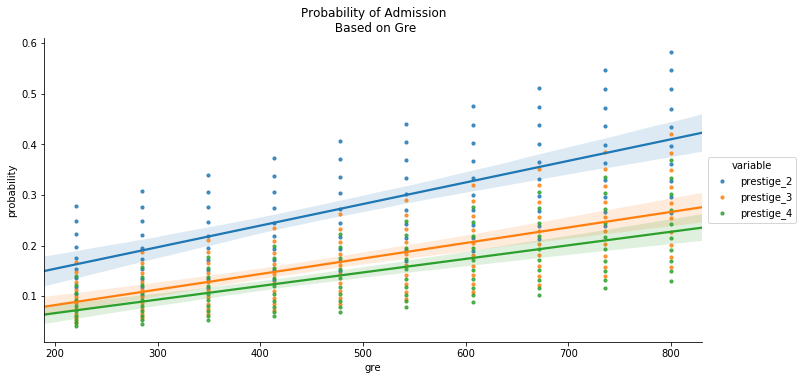

In [253]:
sns.lmplot('gre', 'probability', 
           data=combos, size=5, aspect=2,
           fit_reg=True, hue='variable',
           scatter_kws={'s': 10, 'marker': '.'})
plt.gca().set(title='Probability of Admission\n Based on Gre');

#not quite sure what i'm doing wrong. did my predictions not come out as expected? 

In [183]:
combos.tail()

,gre,probability,variable,value
1183,800.0,0.242159,prestige_4,1
1187,800.0,0.270871,prestige_4,1
1191,800.0,0.301632,prestige_4,1
1195,800.0,0.334286,prestige_4,1
1199,800.0,0.368608,prestige_4,1
